In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import open3d as o3d
import matplotlib.pyplot as plt
import glob

from core import *
from utils import phantom_builder
from utils import geometry
from utils import utils

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [75]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (150,150,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=50, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=3)

pos = 0.02

# test_phantom.add_tissue_sphere((pos,-pos,0), 2, blood)
# test_phantom.add_tissue_sphere((pos,0,0), 4, blood)
# test_phantom.add_tissue_sphere((pos,pos,0), 8, blood)

# test_phantom.add_tissue_sphere((-pos,n-pos,0), 4, fat)
# test_phantom.add_tissue_sphere((-pos,0,0), 8, fat)
# test_phantom.add_tissue_sphere((-pos,pos,0), 2, fat)

# test_phantom.add_tissue_sphere((0,-pos,0), 8, myocardium)
# test_phantom.add_tissue_sphere((0,0,0), 2, myocardium)
# test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.add_tissue_sphere((pos,0,0), 4, myocardium)
test_phantom.add_tissue_sphere((0+0.01,pos-0.01,0), 7, myocardium)
test_phantom.add_tissue_sphere((0,-pos,0), 4, myocardium)
# test_phantom.add_tissue_sphere((-pos,2*pos,0), 6, myocardium)
test_phantom.set_default_tissue('fat')
test = test_phantom.get_complete()
# test_phantom.add_tissue_sphere((0,-pos,0), 4, myocardium)


1933


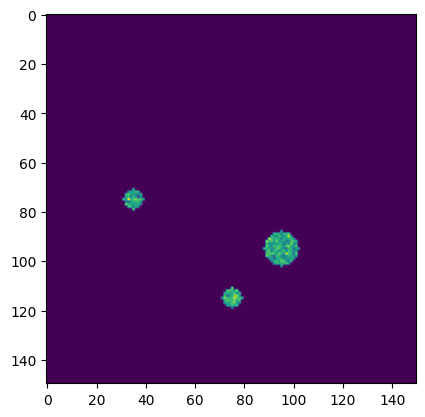

In [76]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])
x = test_phantom.mask
print(np.sum(np.where(x != 3, 1, 0)))


In [77]:
num_transducers = 3
transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 15e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/6,
                                    ray_num = 30, 
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

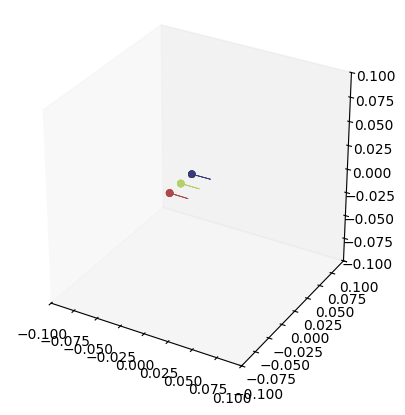

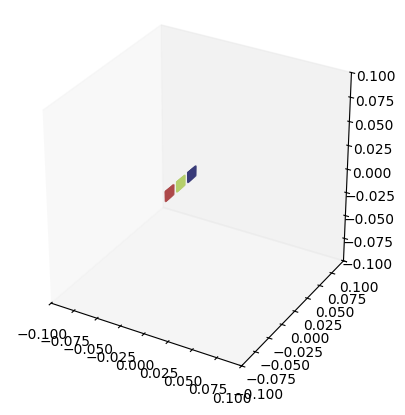

In [80]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([0,0,0], [-0.02,0.02,0]))
cont_transducer_set.assign_pose(2, geometry.Transform([0,0,0], [-0.02,-0.02,0]))
cont_transducer_set.assign_pose(1, geometry.Transform(translation=[-0.02,0,0]))
# test_transducer_set.assign_pose(0, geometry.Transform([-2*np.pi/6,0,0], [-0.01,0.02,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([2*np.pi/6,0,0], [0,-0.02,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([np.pi/20,0,0], [0,-0.02,0]))

cont_transducer_set.plot_transducer_fovs(scale=0.1)
cont_transducer_set.plot_transducer_coords(scale=0.1)

In [81]:
# num_transducers = 2
# transducers_copy = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  10e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/6,
#                                     ray_num = 30, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 50e-3,
#                                     ) for i in range(num_transducers)]

# for t in transducers_copy:
#     t.make_sensor_coords(test_phantom.baseline[0])
# gap_transducer_set = transducer_set.TransducerSet(transducers_copy, seed=8888)
# gap_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01866,0]))
# gap_transducer_set.assign_pose(1, geometry.Transform([np.pi/6,0,0], [0,-0.01866,0]))

# gap_transducer_set.plot_transducer_fovs(scale=0.1)
# gap_transducer_set.plot_transducer_coords(scale=0.1)



In [82]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')
# gap_sensor = sensor.Sensor(transducer_set=gap_transducer_set, aperture_type='extended_aperture')

In [83]:
simprops = simulation.SimProperties(
                grid_size   = (80e-3,60e-3,20e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [84]:
extended_experiment = experiment.Experiment(
                 simulation_path = 'extended_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = ['p_max']
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = 'tar_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = ['p_max']
                 )

# gap_experiment = experiment.Experiment(
#                  simulation_path = '../experiment_files/gap_experiment_ea',
#                  sim_properties  = simprops,
#                  phantom         = test_phantom,
#                  transducer_set  = gap_transducer_set,
#                  sensor          = gap_sensor,
#                  nodes           = 1,
#                  results         = None,
#                  indices         = None,
#                  workers         = 2,
#                  additional_keys = ['p_max']
#                  )

extended_experiment.save()
tar_experiment.save()
# gap_experiment.save()

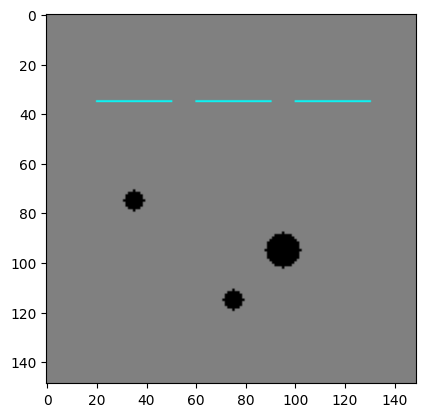

In [85]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])

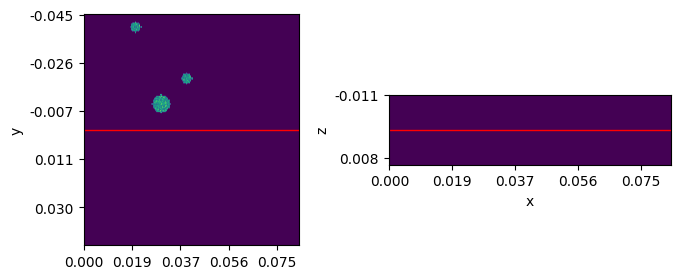

In [86]:
extended_experiment.plot_ray_path(0)

In [87]:
test_experiment = experiment.Experiment.load('extended_aperture')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  7.78it/s]

running with 2 workers



preparation for sim    0 completed in  2.90 seconds
simulation             0 completed in  5.93 seconds
preparation for sim    1 completed in  2.80 seconds
simulation             1 completed in  5.93 seconds
preparation for sim    2 completed in  2.79 seconds
simulation             2 completed in  5.84 seconds
preparation for sim    3 completed in  2.79 seconds
simulation             3 completed in  5.80 seconds
preparation for sim    4 completed in  2.79 seconds
simulation             4 completed in  5.85 seconds
preparation for sim    5 completed in  2.80 seconds
simulation             5 completed in  5.85 seconds
preparation for sim    6 completed in  2.76 seconds
simulation             6 completed in  5.88 seconds
preparation for sim    7 completed in  2.79 seconds
simulation             7 completed in  5.83 seconds
preparation for sim    8 completed in  2.79 seconds
simulation             8 completed in  5.88 seconds
preparation for sim    9 completed in  2.77 seconds
simulation  

In [88]:
test_experiment = experiment.Experiment.load('tar_aperture')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  8.46it/s]

running with 2 workers



preparation for sim    0 completed in  2.74 seconds
simulation             0 completed in  5.83 seconds
preparation for sim    1 completed in  2.74 seconds
simulation             1 completed in  5.82 seconds
preparation for sim    2 completed in  2.75 seconds
simulation             2 completed in  5.85 seconds
preparation for sim    3 completed in  2.75 seconds
simulation             3 completed in  5.85 seconds
preparation for sim    4 completed in  2.74 seconds
simulation             4 completed in  5.81 seconds
preparation for sim    5 completed in  2.72 seconds
simulation             5 completed in  5.82 seconds
preparation for sim    6 completed in  2.73 seconds
simulation             6 completed in  5.80 seconds
preparation for sim    7 completed in  2.72 seconds
simulation             7 completed in  5.80 seconds
preparation for sim    8 completed in  2.72 seconds
simulation             8 completed in  5.86 seconds
preparation for sim    9 completed in  2.73 seconds
simulation  

In [89]:
# test_experiment = experiment.Experiment.load('../experiment_files/gap_experiment_ea')
# test_experiment.run(dry=True)
# test_experiment.run(repeat=False)

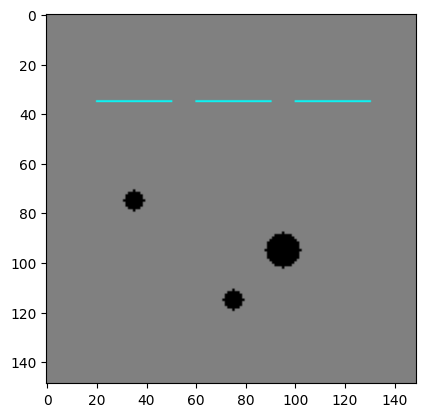

In [90]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])

# Reconstruction

In [114]:
test_experiment = experiment.Experiment.load('tar_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 11.41it/s]


In [115]:
images1 = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 90/90 [00:00<00:00, 1592773.67it/s]


In [116]:
image1 = np.sum(images1, axis=0)
image1t1 = np.sum(images1[:len(images1)//3], axis=0)
image1t2 = np.sum(images1[len(images1)//3:2*len(images1)//3], axis=0)
image1t3 = np.sum(images1[2*len(images1)//3:], axis=0)

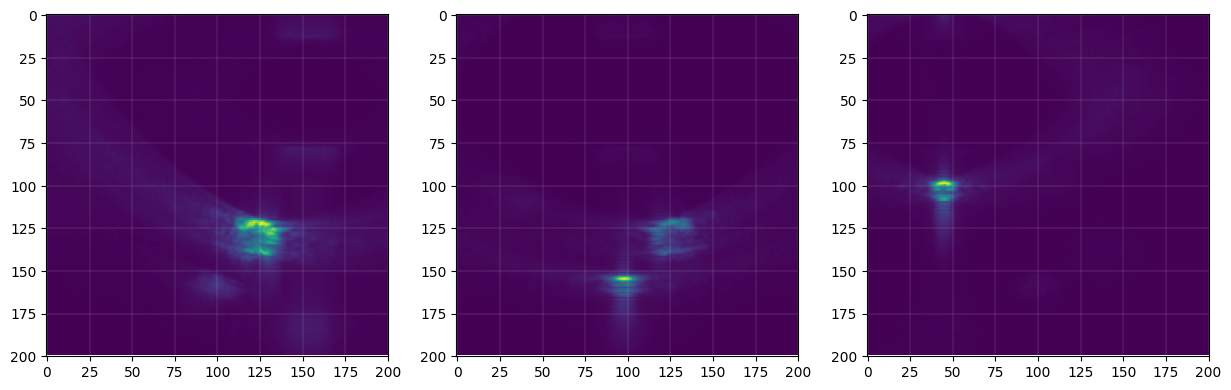

In [131]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(image1t1)
ax[1].imshow(image1t2)
ax[2].imshow(image1t3)

for a in ax:
    a.set_xticks(np.linspace(0, image2.shape[1],9))
    a.set_yticks(np.linspace(0, image2.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)

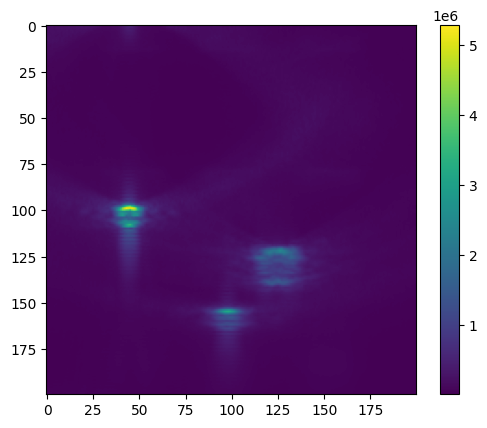

In [118]:
plt.imshow(image1[:,:,image1.shape[2]//2])
plt.colorbar()

In [119]:
test_experiment = experiment.Experiment.load('extended_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 10.06it/s]


In [123]:
images2 = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 90/90 [00:00<00:00, 1540764.73it/s]


In [124]:
image2 = np.sum(images2, axis=0)
image2t1 = np.sum(images2[:len(images2)//3], axis=0)
image2t2 = np.sum(images2[len(images2)//3:2*len(images2)//3], axis=0)
image2t3 = np.sum(images2[2*len(images2)//3:], axis=0)

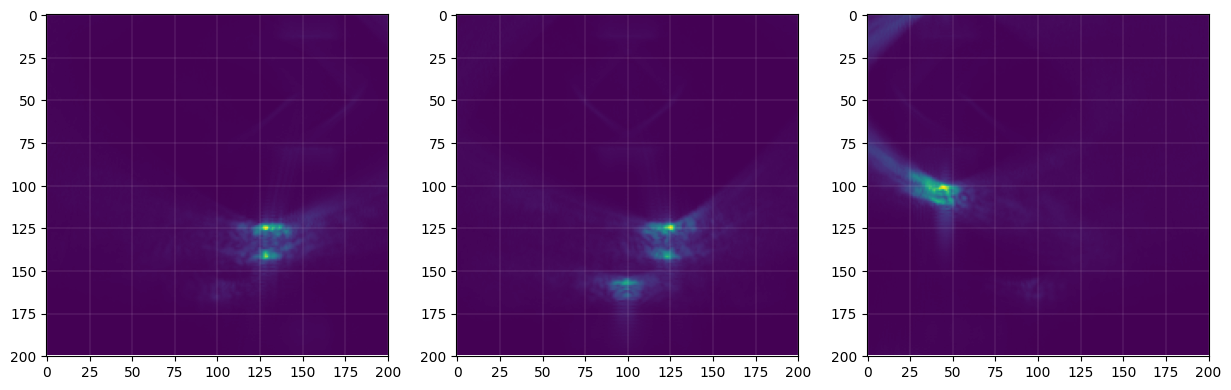

In [130]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(image2t1)
ax[1].imshow(image2t2)
ax[2].imshow(image2t3)

for a in ax:
    a.set_xticks(np.linspace(0, image2.shape[1],9))
    a.set_yticks(np.linspace(0, image2.shape[0],9))
    a.grid(color='w', linestyle='-', linewidth=0.1)


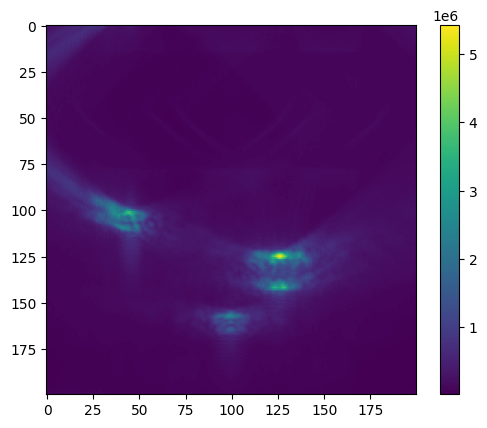

In [126]:
plt.imshow(image2[:,:,image2.shape[2]//2])
plt.colorbar()

In [60]:
# test_experiment = experiment.Experiment.load('../experiment_files/gap_experiment_ea')
# test_experiment.run(dry=True)
# test_experiment.add_results()
# test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [24]:
# image3 = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True)

100%|██████████| 60/60 [00:00<00:00, 1553445.93it/s]


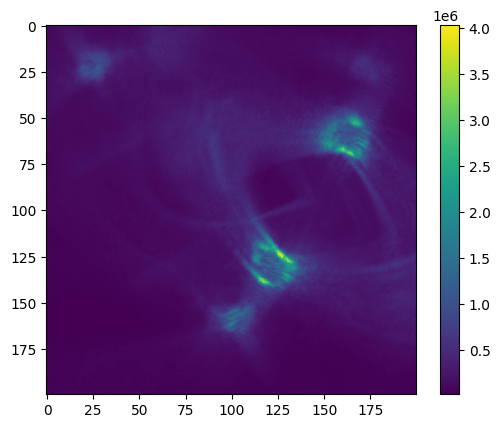

In [25]:
# plt.imshow(image3[:,:,image3.shape[2]//2])
# plt.colorbar()

In [29]:
pfield = utils.load_array('1mhz_pfield.npz')

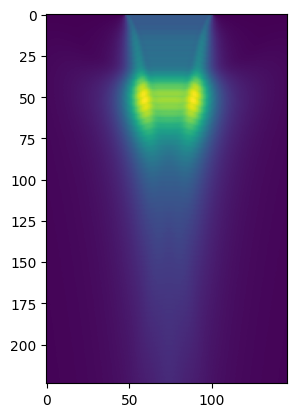

In [30]:
plt.imshow(pfield)

In [31]:
test_experiment = experiment.Experiment.load('../experiment_files/tar_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  7.29it/s]


In [32]:
images1_ap = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, combine=False, pressure_field=pfield)

100%|██████████| 90/90 [00:00<00:00, 1763959.63it/s]


In [ ]:
# plt.imshow(np.sum(images1_ap[:30][:,:,images1_ap[0].shape[2]//2], axis=0))
# # plt.imshow(images1_ap[0][1][:,:,images1_ap[0][1].shape[2]//2], alpha=0.5)
# plt.colorbar()

In [34]:
image1_ap = np.sum(images1_ap, axis=0)
image1t1_ap = np.sum(images1_ap[:len(images1_ap)//3], axis=0)
image1t2_ap = np.sum(images1_ap[len(images1_ap)//3:2*len(images1_ap)//3], axis=0)
image1t3_ap = np.sum(images1_ap[2*len(images1_ap)//3:], axis=0)

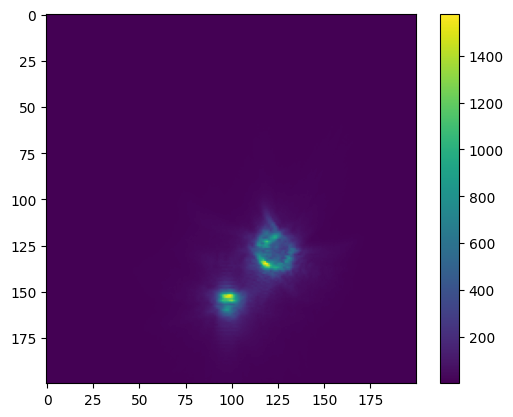

In [35]:
plt.imshow(image1_ap[:,:,image1_ap.shape[2]//2])
plt.colorbar()

In [36]:
test_experiment = experiment.Experiment.load('../experiment_files/extended_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


In [37]:
image2_ap = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, pressure_field=pfield)

100%|██████████| 90/90 [00:00<00:00, 1486170.71it/s]


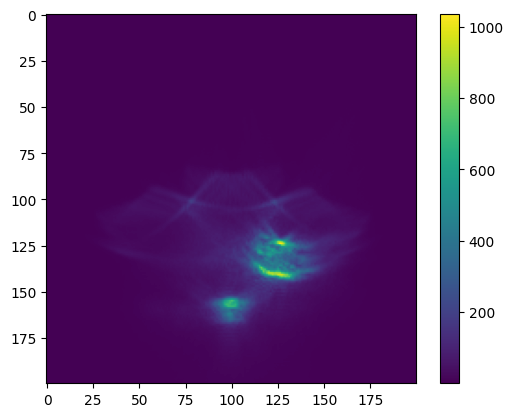

In [38]:
plt.imshow(image2_ap[:,:,image2_ap.shape[2]//2])
plt.colorbar()

In [39]:
test_experiment = experiment.Experiment.load('../experiment_files/gap_experiment_ea')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


In [40]:
image3_ap = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, pressure_field=pfield)

100%|██████████| 60/60 [00:00<00:00, 1039910.08it/s]


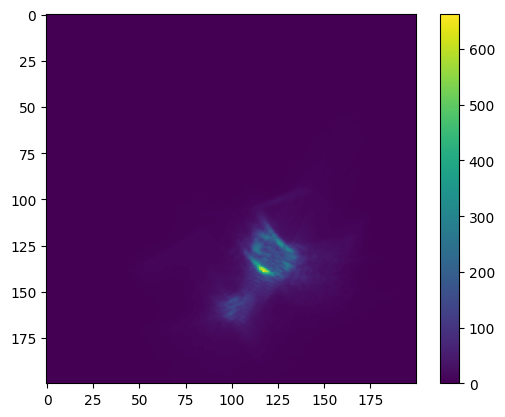

In [41]:
plt.imshow(image3_ap[:,:,image3_ap.shape[2]//2])
plt.colorbar()

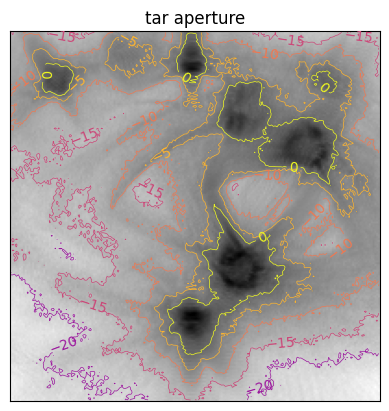

In [42]:
psf = 20 * np.log10(image1 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('tar aperture')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_tar_aperture.png', dpi=300)

In [51]:
np.mean(image)

-112.71189243873782

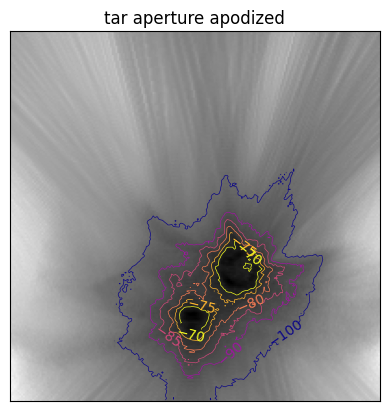

In [64]:
psf = 20 * np.log10(image1_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = np.array([-30,-20,-15,-10,-5,0,])-70)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('tar aperture apodized')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_tar_aperture_apodized.png', dpi=300)

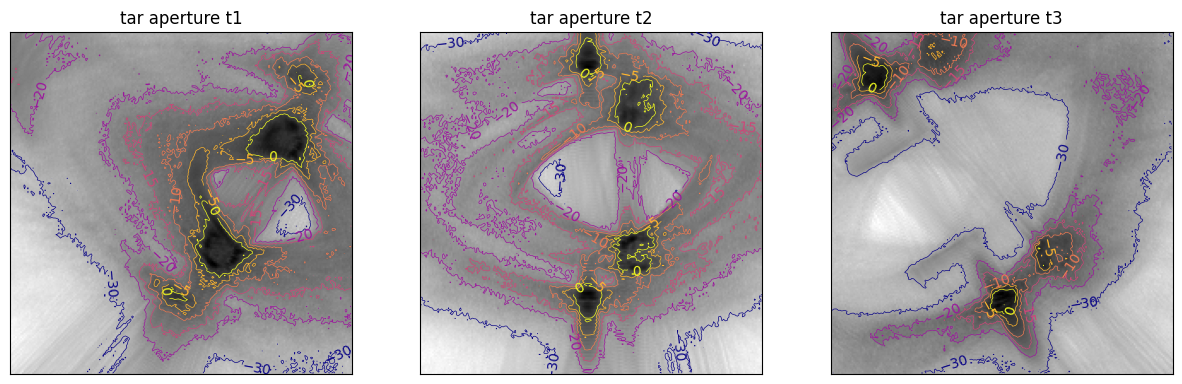

In [61]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

psf = 20 * np.log10(image1t1 / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[0].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[0].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[0].clabel(CS, inline=True, fontsize=10)
ax[0].set_title('tar aperture t1')
ax[0].set_xticks([])
ax[0].set_yticks([])

psf = 20 * np.log10(image1t2 / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[1].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[1].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[1].clabel(CS, inline=True, fontsize=10)
ax[1].set_title('tar aperture t2')
ax[1].set_xticks([])
ax[1].set_yticks([])

psf = 20 * np.log10(image1t3 / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[2].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[2].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].set_title('tar aperture t3')
ax[2].set_xticks([])
ax[2].set_yticks([])



plt.savefig('two_spheres_tar_aperture_components.png', dpi=300)

/tmp/ipykernel_123842/3002945852.py:3: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image1t1_ap / 1000000)
/tmp/ipykernel_123842/3002945852.py:17: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image1t2_ap / 1000000)
/tmp/ipykernel_123842/3002945852.py:31: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image1t3_ap / 1000000)


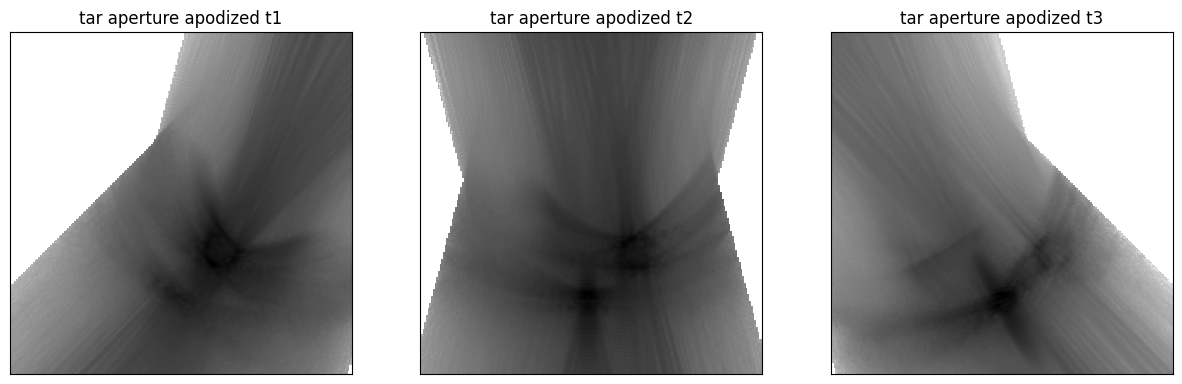

In [71]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

psf = 20 * np.log10(image1t1_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[0].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[0].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[0].clabel(CS, inline=True, fontsize=10)
ax[0].set_title('tar aperture apodized t1')
ax[0].set_xticks([])
ax[0].set_yticks([])

psf = 20 * np.log10(image1t2_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[1].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[1].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[1].clabel(CS, inline=True, fontsize=10)
ax[1].set_title('tar aperture apodized t2')
ax[1].set_xticks([])
ax[1].set_yticks([])

psf = 20 * np.log10(image1t3_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[2].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[2].contour(image, cmap='plasma', linewidths=0.5, levels = np.array([-30,-20,-15,-10,-5,0,]))
ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].set_title('tar aperture apodized t3')
ax[2].set_xticks([])
ax[2].set_yticks([])



plt.savefig('two_spheres_tar_aperture_apodized_components.png', dpi=300)

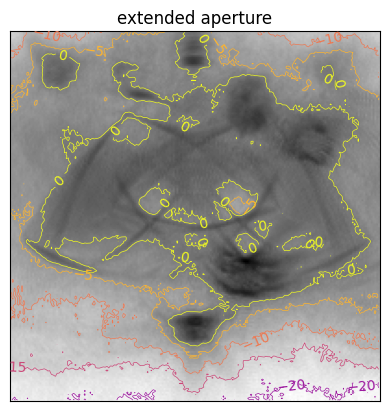

In [72]:
psf = 20 * np.log10(image2 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('extended aperture')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_extended_aperture.png', dpi=300)

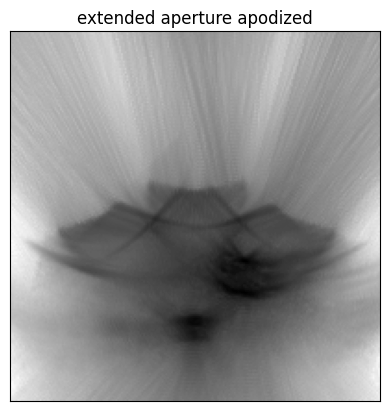

In [73]:
psf = 20 * np.log10(image2_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('extended aperture apodized')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_extended_aperture_apodized.png', dpi=300)

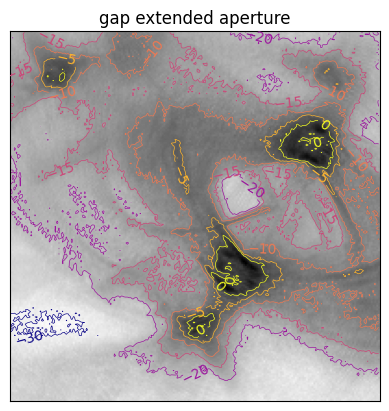

In [74]:
psf = 20 * np.log10(image3 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('gap extended aperture')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_gap_extended_aperture.png', dpi=300)

/tmp/ipykernel_123842/1574245775.py:1: RuntimeWarning: divide by zero encountered in log10
  psf = 20 * np.log10(image3_ap / 1000000)


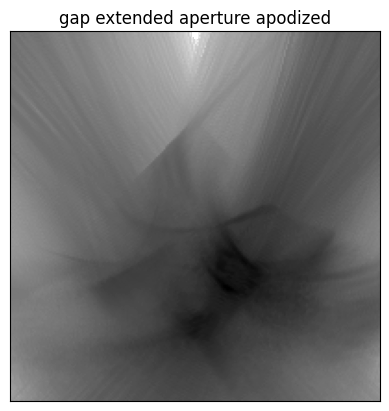

In [75]:
psf = 20 * np.log10(image3_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('gap extended aperture apodized')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_gap_extended_aperture_apodized.png', dpi=300)